# Compare the methods with synthetic event data for different flows
- Show the data of four synthetic flow
- give the one results for different methods
- plot the error curve for uniform flow

In [1]:
import cv2
import numpy as np
import torch

from tqdm.notebook import tqdm
from addict import Dict

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.font_manager import FontProperties
import seaborn as sns

from generator.flow import FlowManager 
from generator.loader import config_events as config
from generator.loader import EventManager
# from utils.spliter import split_events_voxelized
from kernels.pcm import estimatePCM,objective2d_origin,objective2d_smooth

from utils.visualizer import plot_event_time2d


stsong_font = FontProperties(fname=None, family='STSong')

cmap = mpl.colormaps['tab10']
colors = cmap(np.linspace(0, 1, 10))
colors = np.concatenate([colors]*10,axis=0)
markers = ["s", "^", ">", "o", "*", "v", "<", "P", "X", "D"]*10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

Test_mode_flag = True

cuda:0


## 1. Show the test event data

Figure saved to output/Event1.pdf


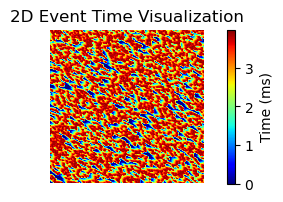

Figure saved to output/Event2.pdf


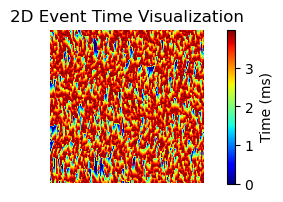

Figure saved to output/Event3.pdf


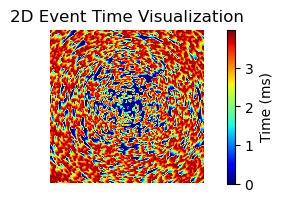

Figure saved to output/Event4.pdf


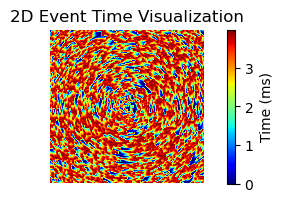

In [2]:
torch.manual_seed(100) # the same seed for the reproducible results

def generator_config():
    cfg = config()
    
    # images
    cfg.density = 0.05
    cfg.width = 256
    cfg.height = 256
    cfg.d = 1.0
    cfg.d_std = 0.2
    cfg.l = 200
    cfg.l_std = 10

    # events generation
    cfg.time_length = 4
    cfg.threshold = 0.25 # the constant fire threshold
    return cfg

# flow1 = FlowManager(mode="analytical", name="uniform", uc=3.0*0.7071,vc=3.0*0.7071)
flow1 = FlowManager(mode="analytical", name="uniform", uc=3.0*0.5,vc=3.0*0.866)
flow2 = FlowManager(mode="analytical", name="sin_flow", x_c=128,y_c=128, a=5, b=128, scale=5)
flow3 = FlowManager(mode="analytical", name="solid_rot", x_c=128,y_c=128, omega=0.03)
flow4 = FlowManager(mode="analytical", name="lamb_oseen", x_c=128, y_c=128, Gamma=2.5e3, rc=64)

def load(flow, output_file):
    flow_func = flow.evaluate
    cfg = generator_config()
    case = Dict(source_type="simulator", path=None, cfg=cfg, flow_func=flow_func)
    event_loader = EventManager(**case)
    evts, (u,v) = event_loader.load()
    plot_event_time2d(evts,output_file)
    return evts, flow_func

evts1,flow_func1 = load(flow1,output_file="output/Event1.pdf")
evts2,flow_func2 = load(flow2,output_file="output/Event2.pdf")
evts3,flow_func3 = load(flow3,output_file="output/Event3.pdf")
evts4,flow_func4 = load(flow4,output_file="output/Event4.pdf")

## 2. Gives the results for different methods

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_1_estimateCC.pdf


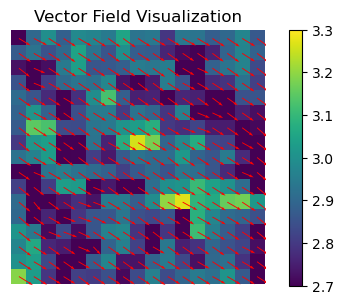

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_1_estimateOF.pdf


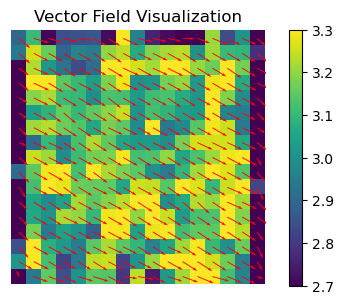

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_1_estimateCMAX.pdf


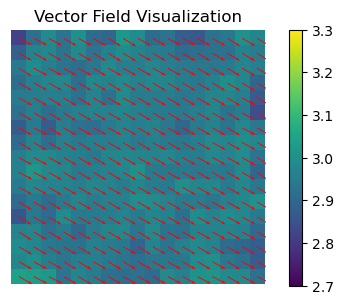

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_1_estimatePCMB.pdf


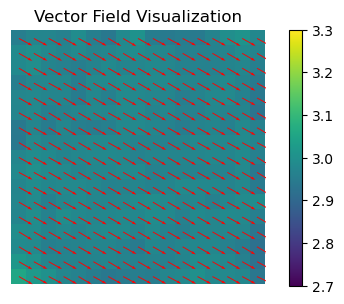

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_1_estimatePCMSA.pdf


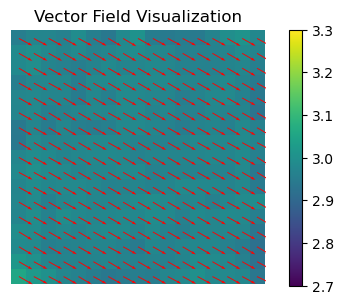

Figure saved to output/Fig3_1_truth.pdf


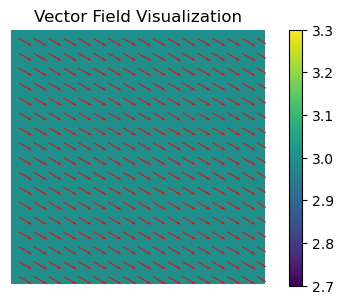

RMSE: [0.32  0.271 0.065 0.046 0.046]
AEE : [0.279 0.237 0.06  0.042 0.042]


In [3]:
from framework import PIVFramework
from addict import Dict
from kernels.correlation import estimateCC
from kernels.opticalflow import estimateOF
from kernels.cmax import estimateCMAX
from kernels.pcm import estimatePCMB, estimatePCMSA

from utils.visualizer import plot_flow_field

def framework_config():
    cfg = Dict()
    cfg.H = 256
    cfg.W = 256
    cfg.step = 16
    cfg.min_events = 0
    cfg.max_events = 3000
    cfg.t_min = 0.5
    cfg.t_max = 2.5
    cfg.x_span = 33
    cfg.y_span = 33
    cfg.start = [0,0]
    cfg.method_args = Dict()
    return cfg

def one_case_exp(evts, flowfunc, case_num=0, v_min=None, v_max=None, scale=None):
    cfg = framework_config()
    rmses, aees = list(), list()
    for method in [estimateCC,estimateOF,estimateCMAX,estimatePCMB,estimatePCMSA]:
    # for method in [estimateCC,estimateOF,estimateCMAX,estimatePCMSA]:
        cfg.method = method
        framework = PIVFramework(cfg)
        u, v, (xx,yy) = framework.compute(evts)
        # 可视化
        output_file=f"output/Fig3_{case_num}_{method.__name__}.pdf"
        plot_flow_field(u, v, output_file=output_file, quiver_step=1,slFlag=False, v_min=v_min, v_max=v_max, scale=scale)
        u_true,v_true = flowfunc(xx,yy)
        u_true = u_true.cpu().detach().numpy()
        v_true = v_true.cpu().detach().numpy()

        epe = np.sqrt(np.square(np.abs(u-u_true))+np.square(np.abs(v-v_true)))
        rmse = np.sqrt(np.nanmean(np.square(epe[2:-2,2:-2])))
        aee = np.nanmean(epe[2:-2,2:-2])
        rmses.append(rmse)
        aees.append(aee)
    
    output_file=f"output/Fig3_{case_num}_truth.pdf"
    plot_flow_field(u_true, v_true, output_file=output_file, quiver_step=1, slFlag=False, v_min=v_min, v_max=v_max, scale=scale)
    print("RMSE:", np.round(rmses, 3))
    print("AEE :", np.round(aees, 3))

one_case_exp(evts1, flow_func1, case_num=1, v_min=2.7, v_max=3.3, scale=50)

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_2_estimateCC.pdf


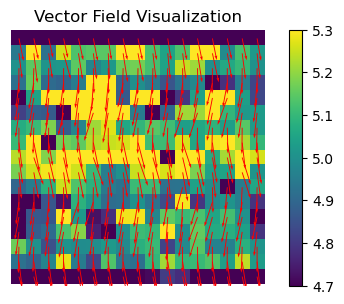

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_2_estimateOF.pdf


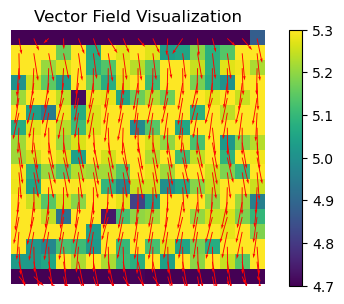

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_2_estimateCMAX.pdf


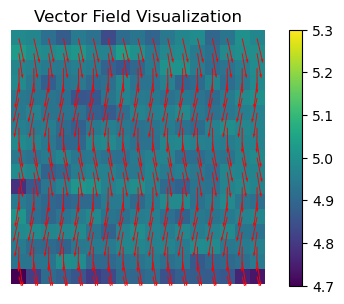

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_2_estimatePCMB.pdf


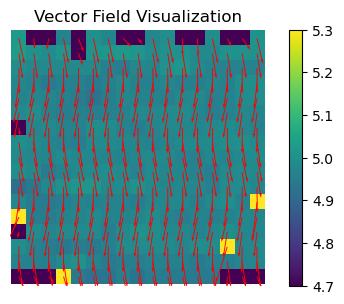

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_2_estimatePCMSA.pdf


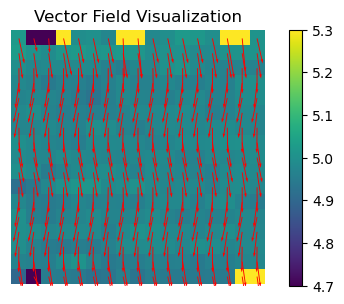

Figure saved to output/Fig3_2_truth.pdf


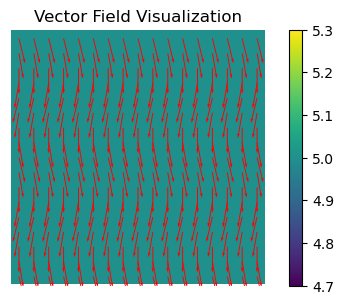

RMSE: [0.469 0.362 0.114 0.253 0.111]
AEE : [0.363 0.33  0.105 0.116 0.099]


In [4]:
one_case_exp(evts2, flow_func2, case_num=2, v_min=4.7, v_max=5.3, scale=50)

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_3_estimateCC.pdf


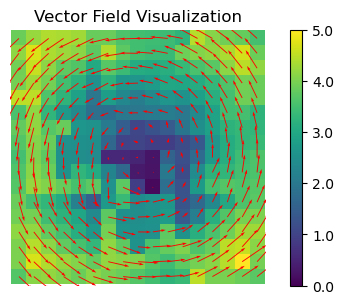

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_3_estimateOF.pdf


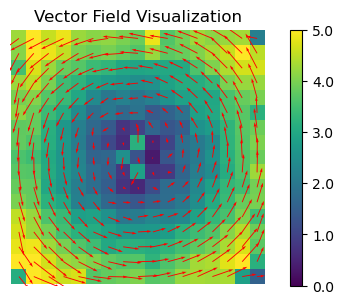

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_3_estimateCMAX.pdf


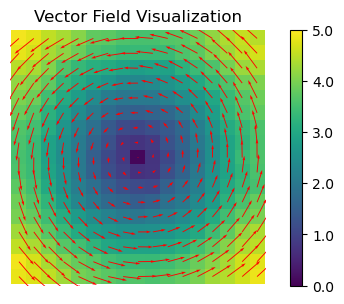

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_3_estimatePCMB.pdf


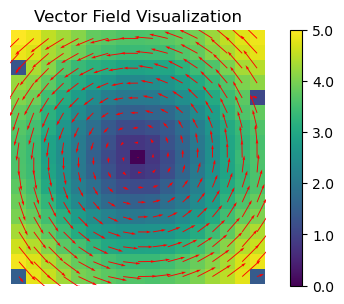

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_3_estimatePCMSA.pdf


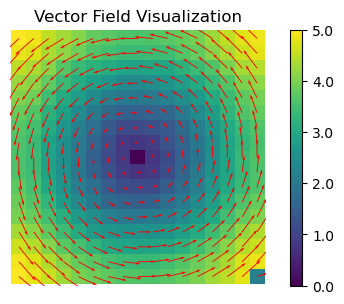

Figure saved to output/Fig3_3_truth.pdf


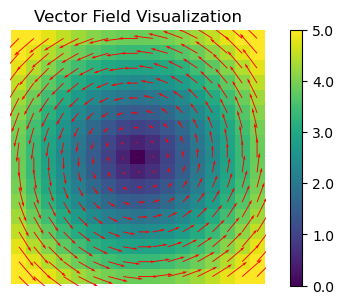

RMSE: [0.705 0.543 0.113 0.113 0.113]
AEE : [0.536 0.363 0.094 0.094 0.094]


In [5]:
one_case_exp(evts3, flow_func3, case_num=3, v_min=0.0, v_max=5.0, scale=50)

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_4_estimateCC.pdf


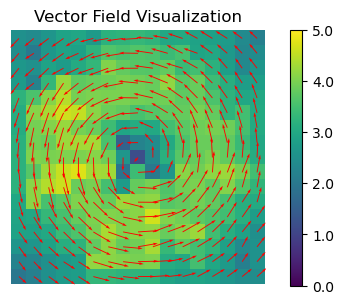

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_4_estimateOF.pdf


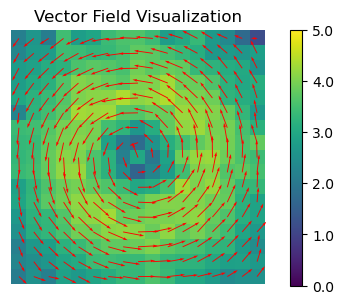

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_4_estimateCMAX.pdf


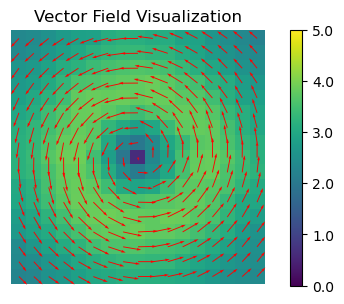

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_4_estimatePCMB.pdf


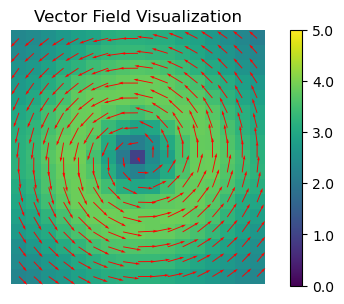

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig3_4_estimatePCMSA.pdf


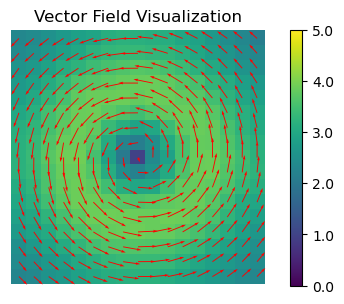

Figure saved to output/Fig3_4_truth.pdf


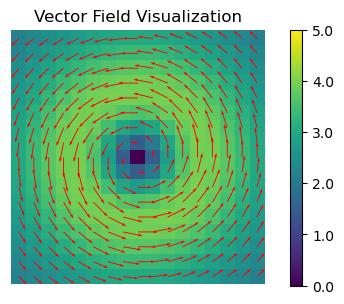

RMSE: [0.477 0.364 0.175 0.182 0.182]
AEE : [0.353 0.261 0.136 0.121 0.121]


In [6]:
one_case_exp(evts4, flow_func4, case_num=4, v_min=0.0, v_max=5.0, scale=50)

In [7]:
# evaluate the non-linear flow effect, 
# we use a moving average filter to quantify the effect
import cv2

def smooth_err(flow_func):
    x,y = torch.meshgrid(torch.linspace(0,255,256, device=device), torch.linspace(0,255,256, device=device), indexing='ij')
    u,v = flow_func(x,y)
    
    
    u_np, v_np = u.cpu().detach().numpy(), v.cpu().detach().numpy()
    u_sm = cv2.blur(u_np, (33,33))
    v_sm = cv2.blur(v_np, (33,33))
    
    u_truth, v_truth = u_np[16::16,16::16], v_np[16::16,16::16]
    u_smoth, v_smoth = u_sm[16::16,16::16], v_sm[16::16,16::16]
    
    epe = np.sqrt(np.square(np.abs(u_smoth-u_truth))+np.square(np.abs(v_smoth-v_truth)))
    rmse = np.sqrt(np.nanmean(np.square(epe[2:-2,2:-2])))
    aee = np.nanmean(epe[2:-2,2:-2])

    print("RMSE:", np.round(rmse, 3))
    print("AEE :", np.round(aee, 3))


smooth_err(flow_func1)
smooth_err(flow_func2)
smooth_err(flow_func3)
smooth_err(flow_func4)

RMSE: 0.0
AEE : 0.0
RMSE: 0.096
AEE : 0.09
RMSE: 0.0
AEE : 0.0
RMSE: 0.085
AEE : 0.08
